In [1]:
from IPython.display import Video, clear_output

import time

import numpy as np
from PIL import Image

import pickle

import json

import os
import subprocess

TOTAL_FRAMES = 5258
FPS = 24

letter_scores = {
    'A': 1,
    'E': 1,
    'I': 1,
    'O': 1,
    'U': 1,
    'L': 1,
    'N': 1,
    'S': 1,
    'T': 1,
    'R': 1,
    'D': 2,
    'G': 2,
    'B': 3,
    'C': 3,
    'M': 3,
    'P': 3,
    'F': 4,
    'H': 4,
    'V': 4,
    'W': 4,
    'Y': 4,
    'K': 5,
    'J': 8,
    'X': 8,
    'Q': 10,
    'Z': 10
}

In [ ]:
Video("assets/englishbadapple24fps.mp4")

In [ ]:
with open("data/scrabble_dictionary.txt", "r") as f:
    scrabble_dictionary = set(f.read().splitlines())
with open("data/lyrics.txt", "r") as f:
    lyrics_list = f.read().splitlines()

In [ ]:
lyrics_text = " ".join(lyrics_list)
print(lyrics_text)

In [ ]:
from package.board import INITIAL_LETTER_BANK

dict_removal_count = 0

for word in list(scrabble_dictionary):
    for alpha, count in INITIAL_LETTER_BANK().items():
        if word.count(alpha) > count + 2:
            scrabble_dictionary.remove(word)
            dict_removal_count += 1
            break

print("Removed a total of %d impossible words." % dict_removal_count)

In [ ]:
def lyrics_check(l, d):
    valid = True
    tile_shift = {}
    for line in l:
        line = line.strip()
        if line not in d:
            valid = False
            print("Invalid word found: %s" % line)
        elif len(line) > 7:
            subwords = sorted(list(filter(lambda s: len(s) <= 7 and len(line) - len(s) <= 7 and s in line, d)))
            closest_distance = 15
            closest_subword = ''
            for subword in subwords:
                index = line.index(subword)
                middle = len(line) // 2
                if index <= middle and index + len(subword) > middle:
                    closest_distance = 0
                elif index < middle and abs(middle - index) < abs(closest_distance):
                    closest_distance = middle - index
                    closest_subword = subword
                elif index + len(subword) >= middle and abs(middle - index) < abs(closest_distance):
                    closest_distance = middle - index
                    closest_subword = subword
            if closest_distance != 0:
                if closest_distance == 15:
                    print("%s cannot be possibly played at the exact center of the board.\n\tPotential subwords: %s\n\tNo valid subwords" % 
                          (line, ', '.join(subwords)))
                    valid = False
                else:
                    print("%s cannot be possibly played at the exact center of the board.\n\tPotential subwords: %s\n\tClosest subword: %s\n\tTile shift: %s" % 
                          (line, ', '.join(subwords), closest_subword, closest_distance))
                    tile_shift[line] = closest_distance
    return valid, tile_shift

is_valid, tile_shift = lyrics_check(lyrics_list, scrabble_dictionary)
print("Lyrics valid✓" if is_valid else "Lyric validation failed with Scrabble dictionary")
assert is_valid

In [ ]:
import stable_whisper as whisper

In [ ]:
timing_model = whisper.load_model("base")
print("Timing model loaded✓")

In [ ]:
timings = timing_model.align("assets/englishbadapple.mp3", lyrics_text, language="en")
print("Timings generated✓")

In [ ]:
timings.save_as_json("cache/timings.json")
print("Timings saved to disk")

In [ ]:
with open("cache/timings.json", "r", encoding='utf-8') as f:
    timing_results = json.load(f)
print("Timings loaded from disk")

In [ ]:
for i in range(len(timing_results["segments"])):
    print(i, timing_results["segments"][i]["text"])

In [ ]:
assert timing_results["text"].strip() == lyrics_text
assert ' '.join([' '.join([word["word"].strip() for word in segment["words"]]) for segment in timing_results["segments"]]) == lyrics_text

In [ ]:
class WordFrame:
    def __init__(self, word, start):
        self.word = word
        self.start = start
        self.shift = tile_shift.get(word, 0)

    def __str__(self):
        return "%d:%02d\t%s" % (self.start // 60, self.start % 60, self.word)

word_frames = []

# Amount at which time markers are advanced, for better visuals
time_advance = 0.1

def manual_fix_timing(previous_word, word):
    if previous_word["word"].strip() == "TO" and word["word"].strip() == "WHITE":
        modified_start = previous_word["start"] + 0.14
        print(word["word"].strip(), word["start"], "-->", modified_start)
        return modified_start
    return word["start"]

previous_word = {"word": "", "start": 0}

for segment in timing_results['segments']:
    for word in segment['words']:
        word_frames.append(WordFrame(word["word"].strip(), manual_fix_timing(previous_word, word) - time_advance))
        previous_word = word

print('\n'.join(map(str, word_frames)))

In [ ]:
from package.trie import Trie

trie = Trie()
trie_reverse = Trie()

for word in scrabble_dictionary:
    trie.add_word(word)
    trie_reverse.add_word(word[::-1])

In [ ]:
trie_words = set(trie.read())
if trie_words != scrabble_dictionary:
    print("Missing or extra words found in Trie:", end='\n\t')
    print('\t\n'.join(list(trie_words.difference(scrabble_dictionary))))
else:
    print("Trie build success✓")
assert trie_words == scrabble_dictionary

In [ ]:
from package.gaddag import Gaddag

In [ ]:
gaddag = Gaddag()

for word in scrabble_dictionary:
    gaddag.add_word(word)

In [ ]:
gaddag_words = gaddag.read()
if gaddag_words != scrabble_dictionary:
    print("Missing or extra words found in GADDAG:", end='\n\t')
    print('\t\n'.join(list(gaddag_words.difference(scrabble_dictionary))))
else:
    print("GADDAG build success✓")
assert gaddag_words == scrabble_dictionary

In [ ]:
class Frame:
    def __init__(self, px):
        self.px = px

    def __eq__(self, other):
        return np.array_equal(self.px, other.px)

frame_info = []

for frame_number in range(1, TOTAL_FRAMES + 1):
    im = Image.open("assets/frames/frame%d.png" % frame_number)
    im = im.resize((15*3, 15*2))
    im = im.convert('L').point(lambda x: 255 if x > 125 else 0, mode='1')

    frames = {}

    for board_i in range(3):
        for board_j in range(2):
            px = im.crop((15*board_i, 15*board_j, 15*(board_i+1), 15*(board_j+1))).load()
            frames[(board_i, board_j)] = Frame(px)
            
    frame_info.append(frames)

In [ ]:
# for f in range(len(frame_info)):
#     info = frame_info[f]
#     print("Frame %d" % (f+1))
#     for j in range(2):
#         for y in range(15):
#             for i in range(3):    
#                 pixels = info[(i, j)].px
#                 for x in range(15):
#                     print('#' if pixels[x,y] == 255 else ' ', end='')
#             print()
#     clear_output(wait=True)

In [ ]:
from package.board import TwoByThreeBoards, Board, Direction, PossibilityMatrix, INITIAL_LETTER_BANK

class Move:
    def __init__(self, pos, word, direction, heuristic=0, score=0, placement_count=0):
        self.pos = pos
        self.word = word
        self.direction = direction
        self.heuristic = heuristic
        self.score = score
        self.placement_count = placement_count

    def __gt__(self, other):
        if self.heuristic == other.heuristic:
            return self.score > other.score
        return self.heuristic > other.heuristic

class BadAppleAlgorithm:
    def __init__(self, px, board, gaddag, letter_scores):
        self.px = px
        self.board = board
        self.gaddag = gaddag
        self.letter_scores = letter_scores
        self.skip_node_cache = {}
        self.racks = [[], []]
        self.current_player_index = 0
        self.temp_rack = []

    def get_heuristic(self, pos):
        x, y = pos
        if not self.board.is_empty(x, y):
            return 0
        if self.px[x,y] == 255:
            return 2
        return -1

    def find_best_prefix(self, pos, node, direction, rack, blanks, word="", heuristic=0, score=0, placement_count=0):
        x, y = pos

        # End of prefix
        if node.letter == '+':
            # Existing tiles continue
            if x >= 0 and y >= 0 and not self.board.is_empty(x, y):
                return None

            # No suffix
            if node.is_terminal:
                x1, y1 = x - direction.value[0], y - direction.value[1]
                x2, y2 = x + (len(word)+1) * direction.value[0], y + (len(word)+1) * direction.value[1]
                if (x1 < 0 or y1 < 0 or self.board.is_empty(x1, y1)) and (x2 >= 15 or y2 >= 15 or self.board.is_empty(x2, y2)):
                    return Move((x + direction.value[0], y + direction.value[1]), word, direction, heuristic, score, placement_count)
            
            # Get best suffix from children
            best_move = None
            for child in node.children.values():
                move = self.find_best_suffix((x + (len(word)+1) * direction.value[0], y + (len(word)+1) * direction.value[1]), child, direction, rack, blanks, word, heuristic, score, placement_count)
                if move is not None:
                    best_move = move if best_move is None else max(best_move, move)
            return best_move

        # Not possible
        if x < 0 or y < 0 or not self.board.can_place_letter(node.letter, pos, direction):
            return None

        updated_rack = rack.copy()

        # Increase placement if new tile
        if self.board.is_empty(x, y):
            if node.letter not in rack:
                if blanks == 0:
                    return None
                else:
                    blanks -= 1
            else:
                updated_rack.remove(node.letter)
            placement_count += 1
        if placement_count > 7:
            return None

        # Update prefix
        word = node.letter + word
        heuristic += self.get_heuristic(pos)
        if heuristic <= -7:
            return None
        score += self.letter_scores.get(node.letter, 0)
        
        # Get best prefix from children
        best_move = None
        for child in node.children.values():
            move = self.find_best_prefix((x - direction.value[0], y - direction.value[1]), child, direction, updated_rack, blanks, word, heuristic, score, placement_count)
            if move is not None:
                best_move = move if best_move is None else max(move, best_move)
        return best_move

    def find_best_suffix(self, pos, node, direction, rack, blanks, word, heuristic, score, placement_count):
        x, y = pos

        # Not possible
        if x >= 15 or y >= 15 or not self.board.can_place_letter(node.letter, pos, direction):
            return None

        updated_rack = rack.copy()

        # Increase placement if new tile
        if self.board.is_empty(x, y):
            if node.letter not in rack:
                if blanks == 0:
                    return None
                else:
                    blanks -= 1
            else:
                updated_rack.remove(node.letter)
            placement_count += 1
        if placement_count > 7:
            return None

        # Update suffix
        word += node.letter
        heuristic += self.get_heuristic(pos)
        if heuristic <= -7:
            return None
        score += self.letter_scores.get(node.letter, 0)
        
        x2, y2 = x + direction.value[0], y + direction.value[1]
            
        # End of suffix
        if node.is_terminal:
            if x2 < 15 and y2 < 15 and not self.board.is_empty(x2, y2):
                return None
            return Move((x - (len(word)-1) * direction.value[0], y - (len(word)-1) * direction.value[1]), word, direction, heuristic, score, placement_count)
        
        # Get best suffix from children
        moves = []
        for child in node.children.values():
            move = self.find_best_suffix((x2, y2), child, direction, updated_rack, blanks, word, heuristic, score, placement_count)
            if move is not None:
                moves.append(move)
        return None if len(moves) == 0 else max(moves)
    
    def get_best_move_in_direction(self, direction, rack):
        rack_without_blanks = rack.copy()
        blanks = rack.count('#')
        for b in range(blanks):
            rack_without_blanks.remove('#')

        best_move = None
        for a in self.board.adjacents:
            x, y = a
            for a_letter in self.board.possibilities[direction].get_possible(x, y):
                for head in self.gaddag.get(a_letter):
                    move = self.find_best_prefix((x, y), head, direction, rack_without_blanks, blanks)
                    if move is None:
                        continue
                    if move.placement_count > 0 and (best_move is None or move > best_move):
                        best_move = move
                        if best_move.heuristic >= 10:
                            return best_move
        return best_move

    def get_best_move(self, rack):
        directions = [Direction.DOWN, Direction.RIGHT]
        random.shuffle(directions)
        move1 = self.get_best_move_in_direction(directions[0], rack)
        if move1 is not None and move1.heuristic >= 10:
            move = move1
        else:
            move2 = self.get_best_move_in_direction(directions[1], rack)
            if move1 is None and move2 is None:
                return None
            if move1 is None:
                return move2
            if move2 is None:
                return move1
            move = max(move1, move2) 
        return move

    def play(self, log=False):
        is_first_branch = True
        skipped_turns = 0
        while True:
            self.racks[self.current_player_index] += self.board.draw_tiles(7 - len(self.racks[self.current_player_index]))
            if log:
                print("Rack: %s" % ' '.join(self.racks[self.current_player_index]))
            move = self.get_best_move(self.racks[self.current_player_index].copy())
            if move is None or move.heuristic < 0:
                if log:
                    print("No good move")
                skipped_turns += 1
                self.current_player_index = 1 - self.current_player_index
                if skipped_turns == len(self.racks):
                    if is_first_branch:
                        self.board.clear()
                    break
                else:
                    continue

            # Reintroduce blanks
            word_with_blanks = ""
            x, y = move.pos
            for letter in move.word:
                if not self.board.is_empty(x, y) and self.board.get_letter(x, y) == letter:
                    word_with_blanks += letter
                elif letter not in self.racks[self.current_player_index] and '#' in self.racks[self.current_player_index]:
                    # Lowercase signifies blank
                    word_with_blanks += letter.lower()
                    self.racks[self.current_player_index].remove('#')
                elif letter in self.racks[self.current_player_index]:
                    word_with_blanks += letter
                    self.racks[self.current_player_index].remove(letter)
                else:
                    raise UserWarning("Attempted to place invalid tile %s at (%d, %d)" % (letter, x, y))
                x, y = x + move.direction.value[0], y + move.direction.value[1]
            move.word = word_with_blanks
        
            if log:
                print(move.pos, move.direction, move.heuristic, move.word)
            skipped_turns = 0
            self.board.place_word(move.word, move.pos, move.direction)
            is_first_branch = False
            self.current_player_index = 1 - self.current_player_index
        if log:
            print("Remaining letters:")
            for alpha, count in alg.board.letter_bank.items():
                print("%s-%d" % (alpha, count), end=" ")
            print()

In [2]:
def verify_board(board):
    bank = INITIAL_LETTER_BANK()
    success = True
    for x in range(15):
        word1 = ""
        word2 = ""
        for y in range(15):
            if board.is_empty(x, y):
                if word1 != "":
                    if len(word1) > 1 and word1 not in scrabble_dictionary:
                        print("Invalid word: (%d, %d) %s" % (x, y, word1))
                        success = False
                    word1 = ""
            else:
                letter = board.get_letter(x, y)
                actual_letter = '#' if board.is_blank(x, y) else letter
                if bank[actual_letter] <= 0:
                    print("Insufficient letters: (%d, %d) %s" % (x, y, actual_letter))
                    success = False
                word1 += letter
                bank[actual_letter] -= 1
            if board.is_empty(y, x):
                if word2 != "":
                    if len(word2) > 1 and word2 not in scrabble_dictionary:
                        print("Invalid word: (%d, %d) %s" % (y, x, word2))
                        success = False
                    word2 = ""
            else:
                letter = board.get_letter(y, x)
                word2 += letter
    return success

In [ ]:
import random
random.seed(0)

test_frame = 41
test_board_index = (2, 1)
scrabble_boards = TwoByThreeBoards(trie, trie_reverse, closeness_threshold=7)
scrabble_boards.clear()
pixels = frame_info[test_frame][test_board_index].px
alg = BadAppleAlgorithm(pixels, scrabble_boards.boards[test_board_index[0]][test_board_index[1]], gaddag, letter_scores)
for y in range(15):
    for x in range(15):
        if (x, y) in alg.board.adjacents:
            print('^', end='')
        else:
            print(alg.board.get_letter(x, y), end='')
    print()
alg.board.possibilities[Direction.RIGHT].print()
alg.board.possibilities[Direction.DOWN].print()
for y in range(15):
    for x in range(15):
        print('#' if pixels[x,y] == 255 else ' ', end='')
    print()
alg.play(log=True)
for y in range(15):
    for x in range(15):
        print(alg.board.get_letter(x, y), end='')
    print()

In [ ]:
if verify_board(alg.board):
    print("Board is valid✓")

In [ ]:
word_frames_iter = iter(word_frames)
next_root_word = next(word_frames_iter)
current_word = None

results = np.empty((15*3,0))

def coord_to_text(i, j):
    vert = ["TOP", "BOTTOM"]
    hori = ["LEFT", "MIDDLE", "RIGHT"]
    return vert[j] + " " + hori[i]

start_time = time.time()
        
for frame_number in range(1, TOTAL_FRAMES + 1):
    frame_time = frame_number / FPS
    
    if next_root_word != None and frame_time >= next_root_word.start:
        next_next_root_word = next(word_frames_iter, None)
        current_word = next_root_word
        next_root_word = next_next_root_word
            
    for i in range(3):
        for j in range(2):
            frame = frame_info[frame_number-1][(i, j)]
            if frame_number > 1:
                print("Generating Frame %d (%s)...\nAverage time: %fs" % (frame_number, coord_to_text(i, j), (time.time() - start_time)/((frame_number-1)*6+i*2+j)))
                prev_frame = frame_info[frame_number-2][(i, j)]
                if frame == prev_frame:
                    continue
            board = scrabble_boards.boards[i][j]
            board.clear()
            if np.any(frame.px):
                alg = BadAppleAlgorithm(frame.px, board, gaddag, letter_scores)
                if current_word is not None:
                    board.place_root_word(current_word.word, current_word.shift)
                    for letter in current_word.word:
                        board.letter_bank[letter] -= 1
                alg.play(log=True)
            if not verify_board(board):
                for y in range(15):
                    for x in range(15):
                        print(board.get_letter(x, y), end='')
                    print()
                raise UserWarning("Invalid board detected")
            clear_output(wait=True)
                            
    results = np.concatenate((results, scrabble_boards.array()), axis=1)

print("All %s frames generated✓" % TOTAL_FRAMES)

In [ ]:
np.save("cache/results.npy", results, allow_pickle=True)
print("Results saved to disk")

In [3]:
results = np.load("cache/results.npy", allow_pickle=True)
print(results.shape)
print("Results loaded from disk")

(45, 157740)
Results loaded from disk


In [ ]:
for i in range(1, TOTAL_FRAMES+1):
    for u in range(2):
        for v in range(3):
            b = Board(None)
            b.board = results[u*15:(u+1)*15, i*15*2+v*15:i*15*2+(v+1)*15].reshape((15, 15))
            if not verify_board(b):
                for y in range(15):
                    for x in range(15):
                        print(b.get_letter(x, y), end='')
                    print()
                raise UserWarning("Invalid board detected")
    for y in range(15*2):
        for x in range(15*3):
            print(results[x,i*15*2+y].decode("utf-8"), end='')
        print()
    print("Frame %d" % i)
    clear_output(wait=True)

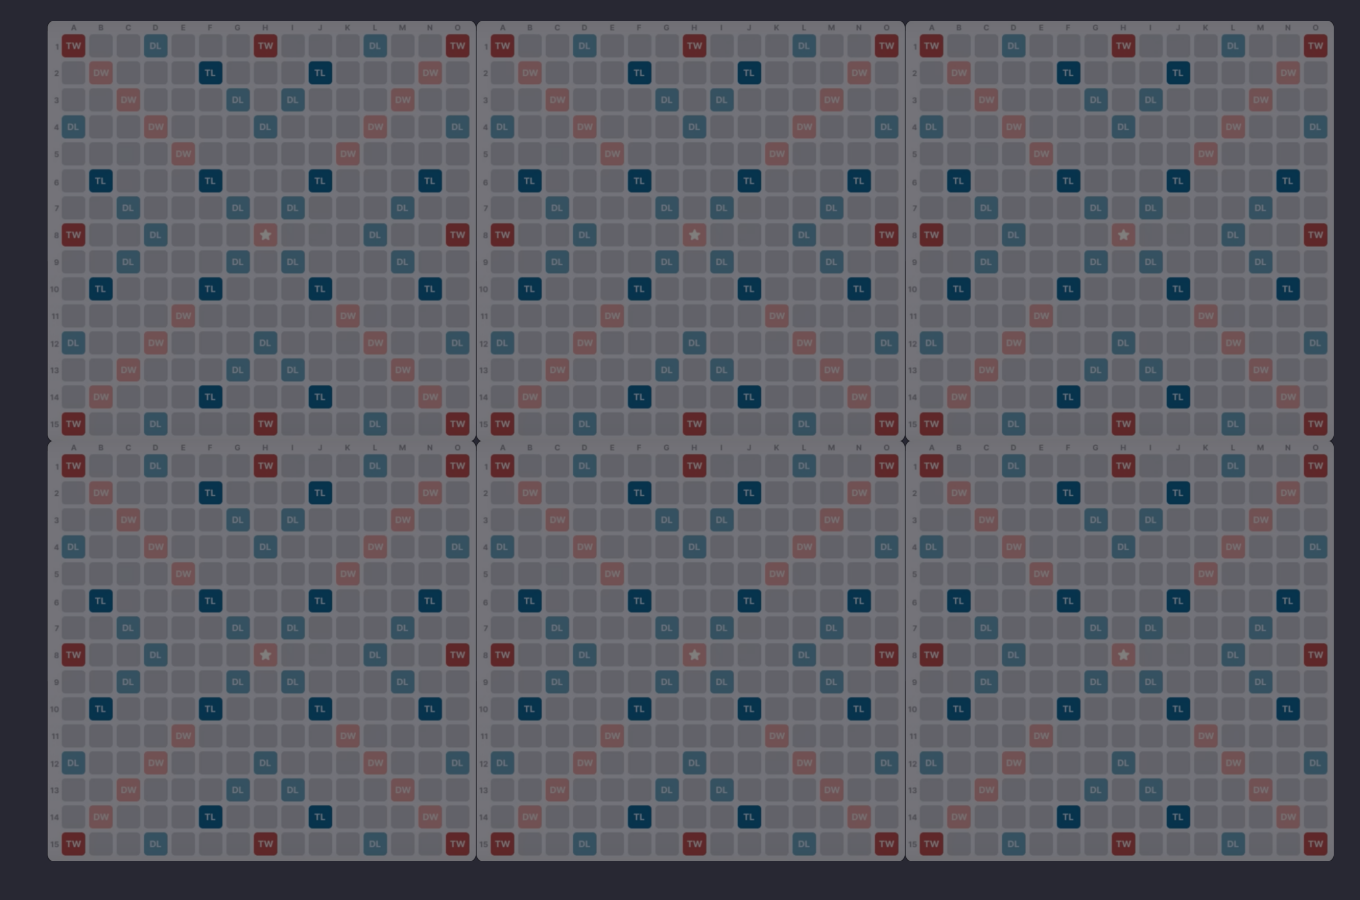

In [4]:
from PIL import ImageDraw, ImageFont

import matplotlib
# matplotlib.use("qt5agg")
import matplotlib.pyplot as plt
import matplotlib.animation as anim

%matplotlib widget

matplotlib.rcParams['animation.embed_limit'] = 2**128
plt.rcParams["figure.figsize"] = (13.6, 9)

class Canvas:
    board_offsets = [
        ((92, 696),
        (736, 696),
        (1380, 696),),
        ((92, 65),
        (736, 65),
        (1380, 65))
    ]

    tile_offset_x = 40.8
    tile_offset_y = 40.2

    def __init__(self, data):
        self.data = data
        
        board_img = Image.open('assets/Board-Dark.png')
        tile_img = Image.open('assets/Tile.png').resize((41, 41))
        
        self.fig, self.axarr = plt.subplots(2, 3, figsize=(13.6, 9), dpi=100)
        # win = self.fig.canvas.window()
        # win.setFixedSize(win.size())
        
        self.fig.tight_layout()
        self.fig.patch.set_facecolor('#282833')
    
        letter_font = ImageFont.truetype('assets/InterstateBold.otf', 24)  
        score_font = ImageFont.truetype('assets/InterstateBold.otf', 12)
        
        self.tile_letter_imgs = {}
        self.tile_letter_imgs['#'] = tile_img
        for letter, score in letter_scores.items():
            img = tile_img.copy()
            draw = ImageDraw.Draw(img)
        
            letter_coords = (12, 7)
            if letter in 'I':
                letter_coords = (17, 7)
            if letter in 'WM':
                letter_coords = (10, 7)
        
            draw.text(letter_coords, letter, fill='black', font = letter_font)
        
            score_coords = (29, 27)
            if letter in 'AM':
                score_coords = (31, 27)
            elif letter in 'F':
                score_coords = (28, 27)
            elif letter in 'QZ':
                score_coords = (25, 27)
        
            draw.text(score_coords, str(score), fill='black', font = score_font, align='right')
            self.tile_letter_imgs[letter] = img
        
        for i in range(2):
            for j in range(3):
                self.axarr[i,j].imshow(board_img)
        
        plt.subplots_adjust(hspace=0, wspace=0)
        
        for i in range(2):
            for j in range(3):
                # Hide grid lines
                self.axarr[i,j].grid(False)
    
                # Hide axes ticks
                self.axarr[i,j].set_xticks([])
                self.axarr[i,j].set_yticks([])
    
                # Hide axes spines
                self.axarr[i,j].spines[['top','left','bottom','right']].set_visible(False)
    
                self.axarr[i,j].set_facecolor('#282833')

        self.tile_cache = {}

    def clear(self):
        for tile in self.tile_cache.values():
            tile.remove()
        self.tile_cache.clear()

    def draw_tile(self, letter, i, j, x, y):
        y = 14 - y
        if (i, j, x, y) in self.tile_cache:
            self.tile_cache[(i, j, x, y)].remove()
            self.tile_cache.pop((i, j, x, y))
        if letter == '-':
            return
        if letter == letter.lower():
            letter = '#'
        x0 = self.board_offsets[i][j][0] + x*self.tile_offset_x
        y0 = self.board_offsets[i][j][1] + y*self.tile_offset_y
        self.tile_cache[(i, j, x, y)] = self.fig.figimage(self.tile_letter_imgs[letter], x0, y0, zorder=1, alpha=1)

    def draw_board(self, index):
        for i in range(2):
            for j in range(3):
                board_index = j+2 + i
                for x in range(15):
                    for y in range(15):
                        letter = self.data[j*15+x,index*15*2+i*15+y].decode("utf-8")
                        if index > 0 and letter == self.data[j*15+x,(index-1)*15*2+i*15+y].decode("utf-8"):
                            continue
                        self.draw_tile(letter, i, j, x, y)

canvas = Canvas(results)

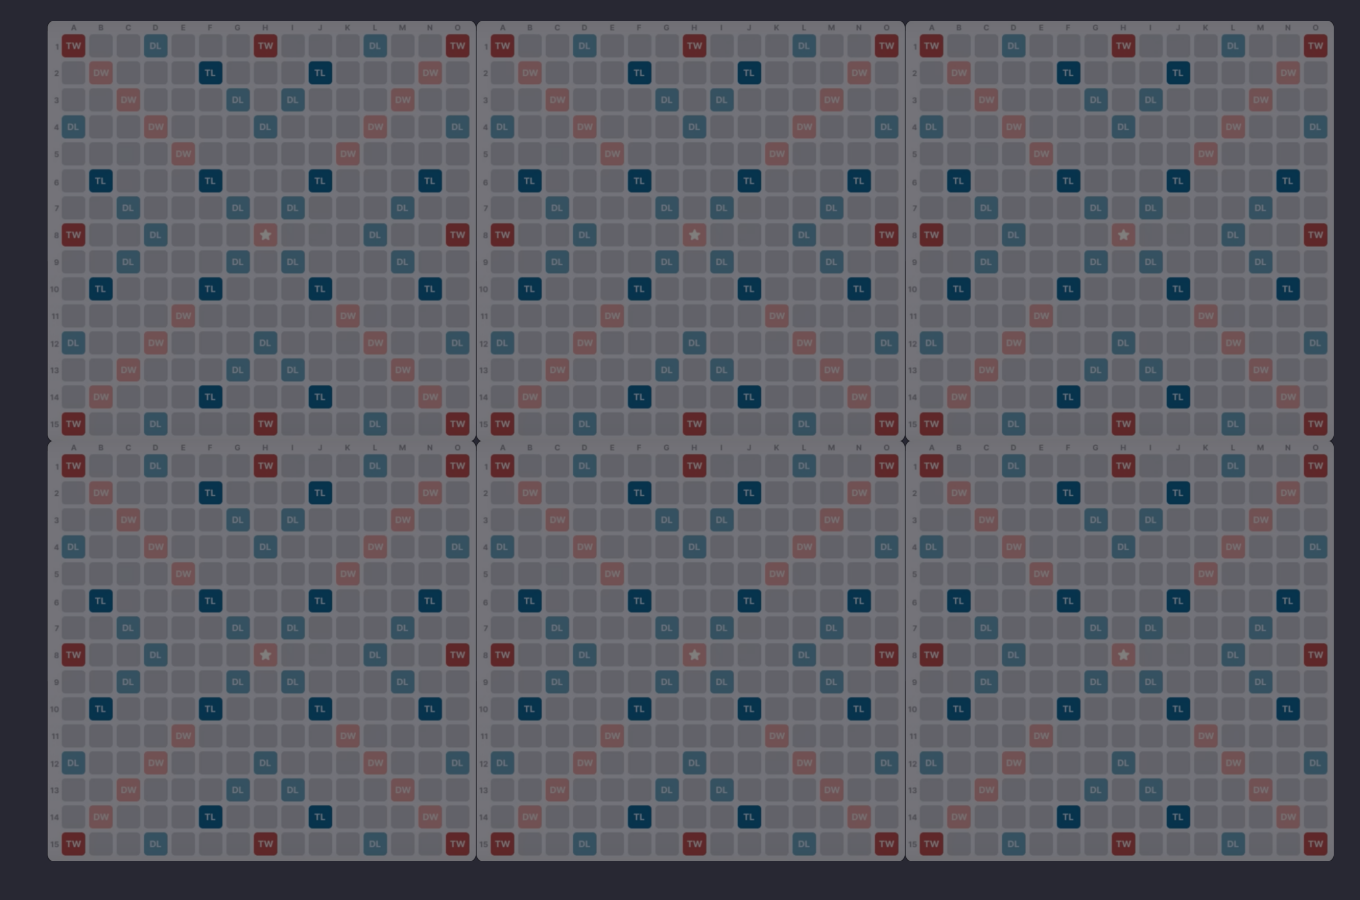

In [5]:
canvas.clear()
test_alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZa"
test_index = 0
test_x = 0
test_y = 0
while test_index < len(test_alphabet):
    canvas.draw_tile(test_alphabet[test_index], 0, 0, test_x, test_y)
    test_index += 1
    test_x += 1
    if test_x >= 15:
        test_x = 0
        test_y += 1
plt.show()

In [ ]:
def update(i):
    print("Rendering frame %d..." % i, end='\r')
    canvas.draw_board(i)

canvas.clear()
render = anim.FuncAnimation(canvas.fig, update, frames=TOTAL_FRAMES, repeat=False)
writervideo = anim.FFMpegWriter(fps=FPS) 
render.save('cache/animation.mp4', writer=writervideo, dpi=150) 

Rendering frame 70...

In [ ]:
Video("cache/animation.mp4", width=1024, height=576)

In [ ]:
result = subprocess.run("ffmpeg -y -i cache/animation.mp4 -i assets/englishbadapple.mp3 -c copy -map 0:v:0 -map 1:a:0 outputs/final.mp4".split(' '), 
                        stdout=subprocess.PIPE, stderr=subprocess.PIPE)
if result.stdout != b'':
    print(result.stdout.decode('utf-8'))
if result.stderr != b'':
    print(result.stderr.decode('utf-8'))

In [ ]:
Video("outputs/final.mp4", width=1024, height=576)